## **“Analisis dan Klasifikasi IPM pada Data Tidak Seimbang Menggunakan Machine Learning”**

Tujuan Laporan

1. Mengeksplorasi dataset IPM untuk memahami distribusi fitur dan ketidakseimbangan kelas.

2. Menangani masalah imbalance menggunakan metode SMOTE agar model belajar dengan lebih adil.

3. Melatih dan membandingkan model machine learning (SVM, KNN, Random Forest) pada data imbalance vs balanced.

4. Mengevaluasi performa model dengan metrik akurasi, F1-score, dan ROC AUC.

5. Memberikan insight dan rekomendasi terkait pengaruh imbalance terhadap performa model klasifikasi IPM.

# Teori dan Konsep Analisis Imbalance pada Klasifikasi IPM

## 1. Imbalanced Data
Imbalanced data terjadi ketika jumlah observasi pada tiap kelas tidak seimbang.  
Dalam dataset IPM, kelas-kelas seperti `Rendah`, `Menengah`, `Tinggi`, dan `Sangat Tinggi` memiliki distribusi yang berbeda, misalnya kelas `Sangat Tinggi` jauh lebih sedikit dibandingkan kelas `Menengah`.  
Hal ini dapat mempengaruhi performa model, karena model cenderung **bias ke kelas mayoritas**.

## 2. Visualisasi Distribusi Kelas
Visualisasi seperti **countplot** digunakan untuk melihat distribusi tiap kelas.  
Tujuannya:
- Mengetahui seberapa besar ketidakseimbangan
- Menentukan strategi balancing yang tepat

## 3. SMOTE (Synthetic Minority Oversampling Technique)
SMOTE adalah teknik oversampling untuk **menyeimbangkan data**.  
- Membuat data sintetis pada kelas minoritas berdasarkan jarak terdekat (k-nearest neighbors)
- Membantu model **tidak bias ke kelas mayoritas**

## 4. Train-Test Split
Membagi data menjadi training dan testing dengan **stratifikasi** memastikan setiap kelas terwakili secara proporsional di kedua set.  
- Meminimalkan bias saat evaluasi model

## 5. Standardisasi Fitur
StandardScaler digunakan untuk **menormalkan fitur** sehingga semua fitur berada pada skala yang sama.  
- Penting untuk algoritma seperti **SVM dan KNN** yang sensitif terhadap skala fitur

## 6. Model Klasifikasi
Tiga model utama digunakan:
1. **SVM (Support Vector Machine)**: Memisahkan kelas dengan hyperplane optimal  
2. **KNN (K-Nearest Neighbors)**: Mengklasifikasikan berdasarkan jarak ke tetangga terdekat  
3. **Random Forest**: Ensemble tree untuk menangkap pola kompleks

## 7. Evaluasi Model
- **Confusion Matrix**: Menunjukkan prediksi vs aktual tiap kelas  
- **Classification Report**: Menyediakan precision, recall, f1-score per kelas  
- **ROC AUC**: Menunjukkan kemampuan model membedakan kelas secara keseluruhan

## 8. Insight dari Analisis Imbalance
- Model yang dilatih pada data **imbalance cenderung memiliki akurasi tinggi untuk kelas mayoritas**, tetapi rendah untuk kelas minoritas  
- Setelah **SMOTE**, performa model lebih seimbang di semua kelas  
- Evaluasi macro F1 dan ROC AUC menunjukkan **perbaikan signifikan pada kemampuan model membedakan kelas minoritas**

## 9. Rekomendasi
- Selalu cek distribusi kelas sebelum modeling  
- Gunakan teknik balancing (misal SMOTE) bila kelas tidak seimbang  
- Evaluasi dengan **metric per kelas** (precision, recall, f1-score, ROC AUC) agar model tidak bias


## Step 1: Import Library
**Tujuan: Menyiapkan library untuk analisis, preprocessing, modeling, dan visualisasi.**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import missingno as msno
sns.set(style='whitegrid')

## Step 2: Load Data
**Tujuan: Memuat dataset dan melihat ringkasan awal.**

In [ ]:
data = pd.read_excel('/content/dataset klasifikasi IPM.xlsx', sheet_name='Dataset Imbalance')
display(data.head())
display(data.info())
display(data.describe())
data['Class'] = pd.cut(data['IPM'], bins=[0,60,69.9,79.9,np.inf], labels=['Rendah','Menengah','Tinggi','Sangat.Tinggi'], right=False)
data2 = data.drop(columns=[data.columns[0], data.columns[7]])
display(data2.head())

,Kabkota,HLS,PENG,RLS,UHH,IDG,IKK,IPM
0,Lombok Barat,13.95,11334,6.42,67.19,57.56,0.31,68.61
1,Lombok Tengah,13.85,9962,6.29,66.38,60.13,0.35,66.72
2,Lombok Timur,13.90,9450,6.71,66.16,65.99,0.88,66.66
3,Sumbawa,13.07,9167,8.15,67.73,70.15,0.41,68.01
4,Dompu,13.53,8899,8.72,66.99,64.45,0.25,68.45


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Kabkota  176 non-null    object 
 1   HLS      176 non-null    float64
 2   PENG     176 non-null    int64  
 3   RLS      176 non-null    float64
 4   UHH      176 non-null    float64
 5   IDG      176 non-null    float64
 6   IKK      176 non-null    float64
 7   IPM      176 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 11.1+ KB


None

,HLS,PENG,RLS,UHH,IDG,IKK,IPM
count,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000
mean,12.745795,8832.931818,8.054261,67.430739,62.805455,0.980341,66.415170
std,1.724766,2508.511781,1.893538,3.230151,11.064596,1.224259,7.593973
min,3.870000,3976.000000,1.420000,55.430000,34.540000,0.070000,32.840000
25%,12.357500,7300.000000,7.342500,65.845000,56.255000,0.290000,64.112500
50%,12.885000,8553.000000,8.155000,67.470000,63.965000,0.590000,66.660000
75%,13.515000,10269.750000,8.975000,70.030000,70.610000,1.100000,70.260000
max,16.890000,17097.000000,12.510000,73.830000,87.290000,8.120000,84.150000


,HLS,PENG,RLS,UHH,IDG,IKK,Class
0,13.95,11334,6.42,67.19,57.56,0.31,Menengah
1,13.85,9962,6.29,66.38,60.13,0.35,Menengah
2,13.90,9450,6.71,66.16,65.99,0.88,Menengah
3,13.07,9167,8.15,67.73,70.15,0.41,Menengah
4,13.53,8899,8.72,66.99,64.45,0.25,Menengah


## Step 3: Cek Missing Value
**Tujuan: Mengecek missing value sebelum analisis.**

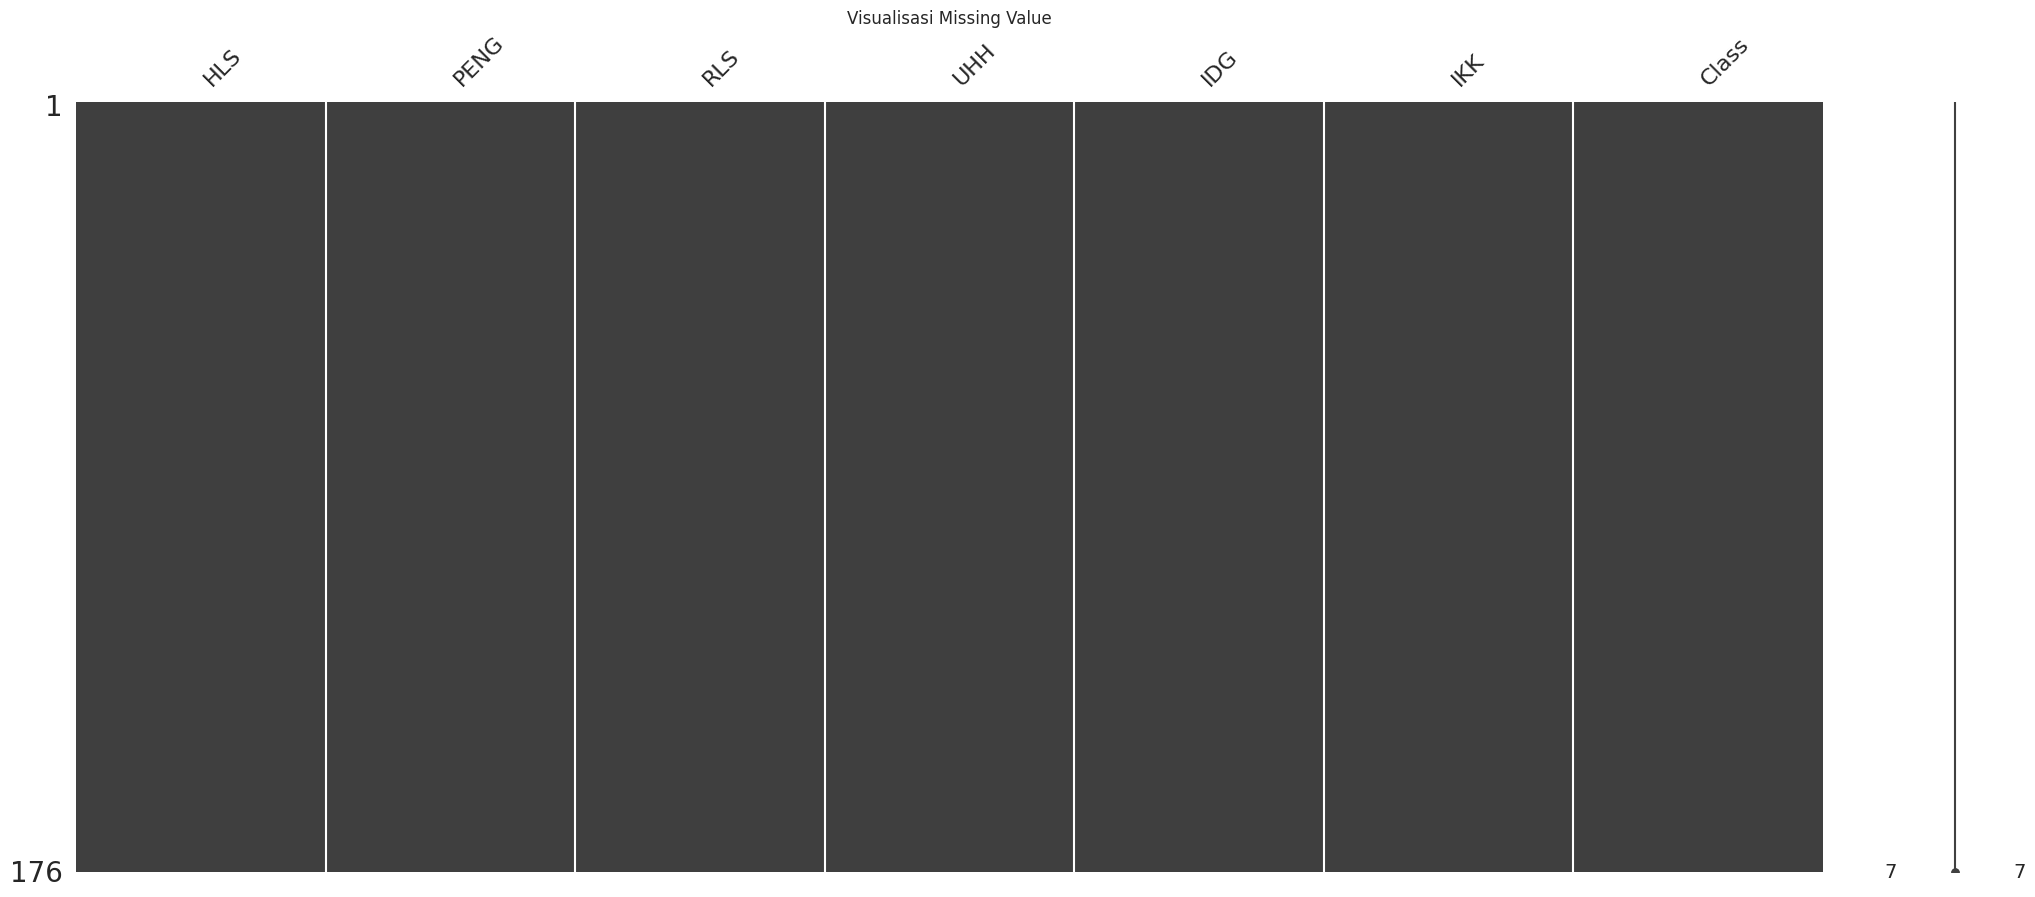

In [ ]:
msno.matrix(data2)
plt.title('Visualisasi Missing Value')
plt.show()

## Step 4: Visualisasi Distribusi Imbalance
**Tujuan: Menunjukkan ketidakseimbangan data per kelas.**

/tmp/ipython-input-1074307204.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=data2, palette=['steelblue','tomato','red','blue'])


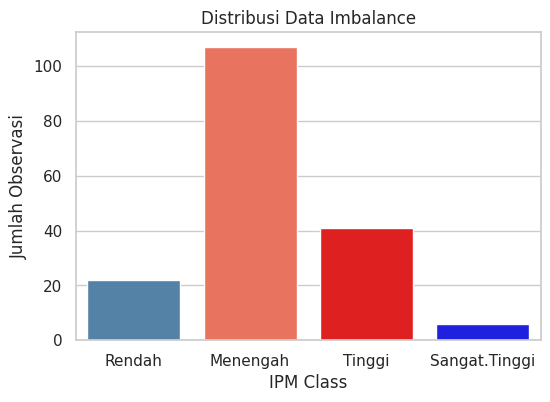

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=data2, palette=['steelblue','tomato','red','blue'])
plt.title('Distribusi Data Imbalance')
plt.xlabel('IPM Class')
plt.ylabel('Jumlah Observasi')
plt.show()

## Step 5: Boxplot Fitur per Kelas
**Tujuan: Memvisualisasikan distribusi tiap fitur berdasarkan kelas untuk memahami sebaran data.**

/tmp/ipython-input-1818009777.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y=col, data=data2, palette='Set2')
/tmp/ipython-input-1818009777.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y=col, data=data2, palette='Set2')
/tmp/ipython-input-1818009777.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y=col, data=data2, palette='Set2')
/tmp/ipython-input-1818009777.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variabl

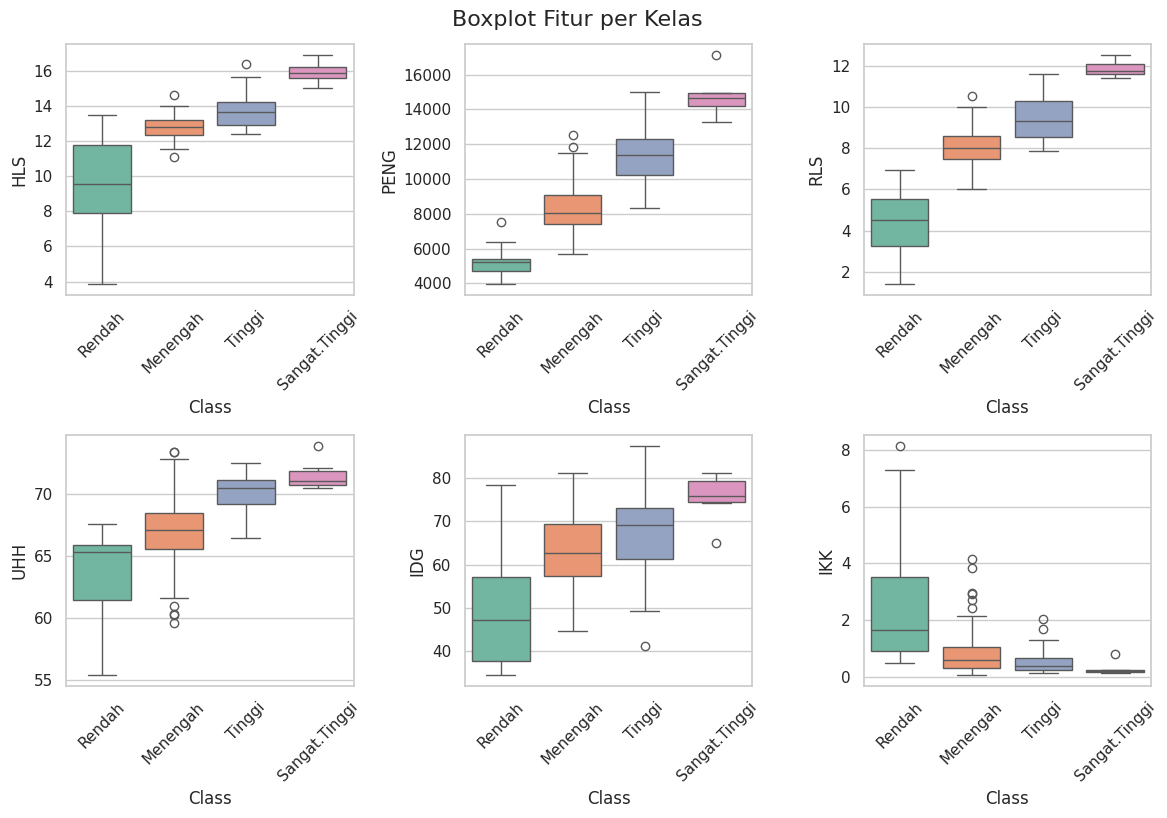

In [ ]:
features = data2.drop(columns=['Class']).columns
plt.figure(figsize=(12,8))
for i, col in enumerate(features,1):
    plt.subplot(2,3,i)
    sns.boxplot(x='Class', y=col, data=data2, palette='Set2')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.suptitle('Boxplot Fitur per Kelas', y=1.02, fontsize=16)
plt.show()

## Step 6: Balancing Data dengan SMOTE
**Tujuan: Mengatasi imbalance sehingga tiap kelas memiliki jumlah yang sama.**

/tmp/ipython-input-449163605.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=data_balanced, palette=['steelblue','tomato','red','blue'])


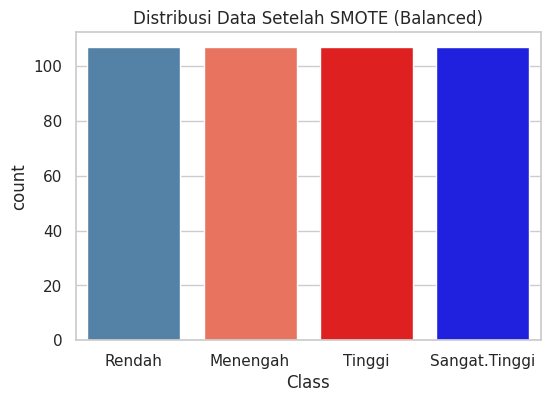

In [ ]:
from imblearn.over_sampling import SMOTE

X = data2.drop(columns=['Class'])
y = data2['Class']

# Untuk multi-class, gunakan 'not majority' agar semua kelas diseimbangkan dengan kelas terbanyak
smote = SMOTE(sampling_strategy='not majority', k_neighbors=5, random_state=1)
X_res, y_res = smote.fit_resample(X, y)

data_balanced = pd.DataFrame(X_res, columns=X.columns)
data_balanced['Class'] = y_res

# Visualisasi distribusi
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=data_balanced, palette=['steelblue','tomato','red','blue'])
plt.title('Distribusi Data Setelah SMOTE (Balanced)')
plt.show()


# **Step Standarisasi**

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_res)  # setelah SMOTE


## Step 7: Split Data Training & Testing
**Tujuan: Membagi data menjadi training dan testing untuk evaluasi model.**

In [ ]:
X_train_im, X_test_im, y_train_im, y_test_im = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=123
)
X_train_bl, X_test_bl, y_train_bl, y_test_bl = train_test_split(
    X_res, y_res, test_size=0.2, stratify=y_res, random_state=123
)

print('Distribusi Training Imbalance:')
print(y_train_im.value_counts(normalize=True))

print('Distribusi Training Balanced:')
print(y_train_bl.value_counts(normalize=True))


Distribusi Training Imbalance:
Class
Menengah         0.607143
Tinggi           0.235714
Rendah           0.121429
Sangat.Tinggi    0.035714
Name: proportion, dtype: float64
Distribusi Training Balanced:
Class
Menengah         0.251462
Tinggi           0.251462
Rendah           0.248538
Sangat.Tinggi    0.248538
Name: proportion, dtype: float64


## Step 8: Training SVM
**Tujuan: Melatih model SVM pada data Imbalance & Balanced dengan cross-validation.**

In [ ]:
pipeline_svm = Pipeline([('scaler', StandardScaler()), ('svm', SVC(kernel='rbf', probability=True))])
param_grid = {'svm__C':[0.1,1,10,100]}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=123)
grid_svm_im = GridSearchCV(pipeline_svm, param_grid, cv=cv, scoring='accuracy')
grid_svm_im.fit(X_train_im, y_train_im)
grid_svm_bl = GridSearchCV(pipeline_svm, param_grid, cv=cv, scoring='accuracy')
grid_svm_bl.fit(X_train_bl, y_train_bl)
print('Best Params SVM Imbalance:', grid_svm_im.best_params_)
print('Best Params SVM Balanced:', grid_svm_bl.best_params_)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


Best Params SVM Imbalance: {'svm__C': 1}
Best Params SVM Balanced: {'svm__C': 10}


## Step 9: Visualisasi Akurasi SVM
**Tujuan: Membandingkan akurasi SVM pada dataset Imbalance vs Balanced.**

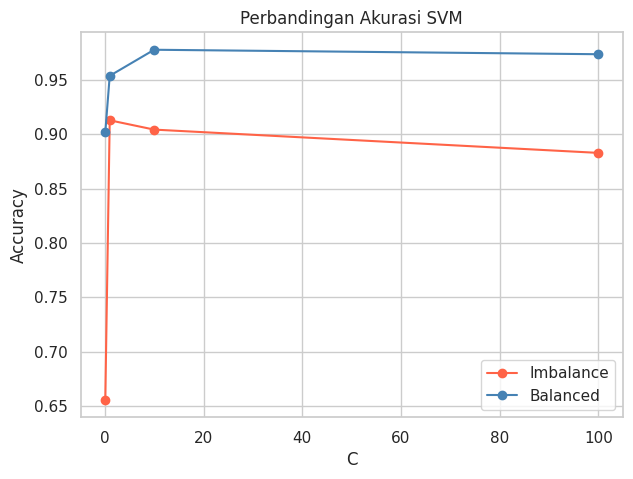

In [ ]:
acc_svm_im = grid_svm_im.cv_results_['mean_test_score']
acc_svm_bl = grid_svm_bl.cv_results_['mean_test_score']
C_values = param_grid['svm__C']
plt.figure(figsize=(7,5))
plt.plot(C_values, acc_svm_im, marker='o', label='Imbalance', color='tomato')
plt.plot(C_values, acc_svm_bl, marker='o', label='Balanced', color='steelblue')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Perbandingan Akurasi SVM')
plt.legend()
plt.show()

## Step 10: Training KNN
**Tujuan: Melatih model KNN dan membandingkan akurasinya.**

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


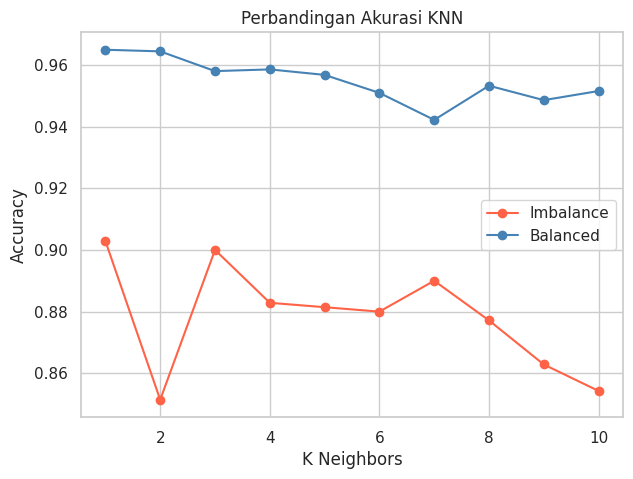

In [ ]:
pipeline_knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
param_grid_knn = {'knn__n_neighbors': list(range(1,11))}
grid_knn_im = GridSearchCV(pipeline_knn, param_grid_knn, cv=cv, scoring='accuracy')
grid_knn_im.fit(X_train_im, y_train_im)
grid_knn_bl = GridSearchCV(pipeline_knn, param_grid_knn, cv=cv, scoring='accuracy')
grid_knn_bl.fit(X_train_bl, y_train_bl)
acc_knn_im = grid_knn_im.cv_results_['mean_test_score']
acc_knn_bl = grid_knn_bl.cv_results_['mean_test_score']
k_values = param_grid_knn['knn__n_neighbors']
plt.figure(figsize=(7,5))
plt.plot(k_values, acc_knn_im, marker='o', label='Imbalance', color='tomato')
plt.plot(k_values, acc_knn_bl, marker='o', label='Balanced', color='steelblue')
plt.xlabel('K Neighbors')
plt.ylabel('Accuracy')
plt.title('Perbandingan Akurasi KNN')
plt.legend()
plt.show()

## Step 11: Training Random Forest
**Tujuan: Melatih Random Forest dan membandingkan akurasinya.**

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


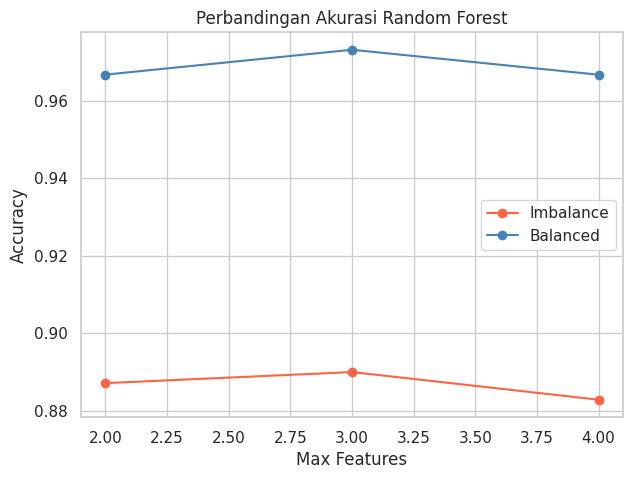

In [ ]:
pipeline_rf = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier(random_state=123))])
param_grid_rf = {'rf__n_estimators':[100,200], 'rf__max_features':[2,3,4]}
grid_rf_im = GridSearchCV(pipeline_rf, param_grid_rf, cv=cv, scoring='accuracy')
grid_rf_im.fit(X_train_im, y_train_im)
grid_rf_bl = GridSearchCV(pipeline_rf, param_grid_rf, cv=cv, scoring='accuracy')
grid_rf_bl.fit(X_train_bl, y_train_bl)
plt.figure(figsize=(7,5))
plt.plot([2,3,4], grid_rf_im.cv_results_['mean_test_score'][:3], marker='o', label='Imbalance', color='tomato')
plt.plot([2,3,4], grid_rf_bl.cv_results_['mean_test_score'][:3], marker='o', label='Balanced', color='steelblue')
plt.xlabel('Max Features')
plt.ylabel('Accuracy')
plt.title('Perbandingan Akurasi Random Forest')
plt.legend()
plt.show()

## Step 12: Confusion Matrix & Summary SVM
**Tujuan: Mengevaluasi performa SVM pada data testing dan menampilkan summary.**

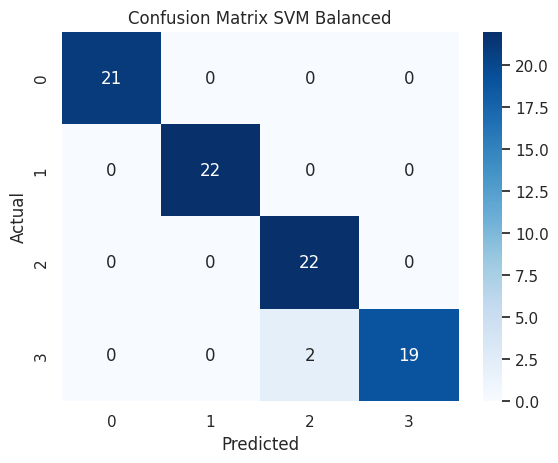

,precision,recall,f1-score,support
Menengah,1.00,1.00,1.00,21.00
Rendah,1.00,1.00,1.00,22.00
Sangat.Tinggi,0.92,1.00,0.96,22.00
Tinggi,1.00,0.90,0.95,21.00
accuracy,0.98,0.98,0.98,0.98
macro avg,0.98,0.98,0.98,86.00
weighted avg,0.98,0.98,0.98,86.00


In [ ]:
y_pred_svm_bl = grid_svm_bl.predict(X_test_bl)
cm = confusion_matrix(y_test_bl, y_pred_svm_bl)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix SVM Balanced')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
report = classification_report(y_test_bl, y_pred_svm_bl, output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report.round(2))

## Step 13: Confusion Matrix KNN & RF
**Tujuan: Mengevaluasi performa KNN dan Random Forest pada data testing.**

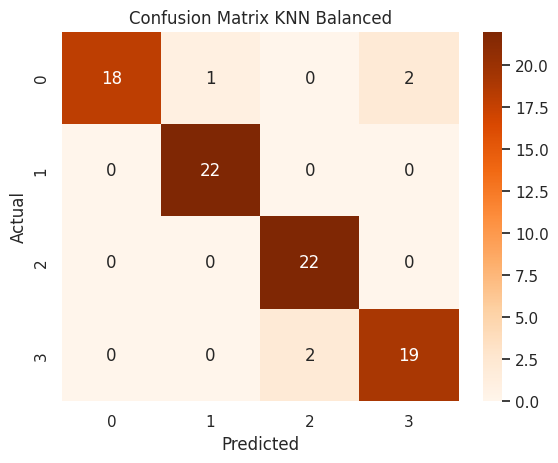

,precision,recall,f1-score,support
Menengah,1.00,0.86,0.92,21.00
Rendah,0.96,1.00,0.98,22.00
Sangat.Tinggi,0.92,1.00,0.96,22.00
Tinggi,0.90,0.90,0.90,21.00
accuracy,0.94,0.94,0.94,0.94
macro avg,0.94,0.94,0.94,86.00
weighted avg,0.94,0.94,0.94,86.00


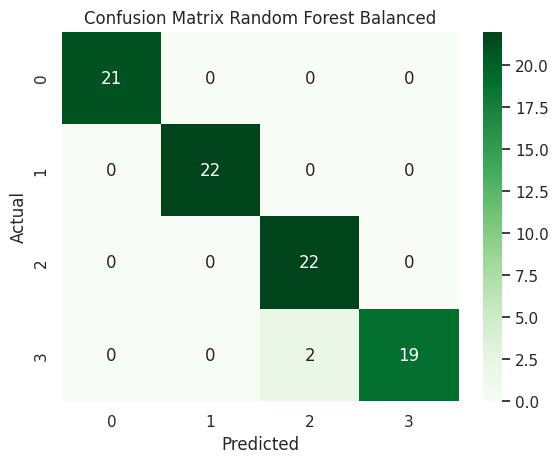

,precision,recall,f1-score,support
Menengah,1.00,1.00,1.00,21.00
Rendah,1.00,1.00,1.00,22.00
Sangat.Tinggi,0.92,1.00,0.96,22.00
Tinggi,1.00,0.90,0.95,21.00
accuracy,0.98,0.98,0.98,0.98
macro avg,0.98,0.98,0.98,86.00
weighted avg,0.98,0.98,0.98,86.00


In [ ]:
y_pred_knn_bl = grid_knn_bl.predict(X_test_bl)
cm_knn = confusion_matrix(y_test_bl, y_pred_knn_bl)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix KNN Balanced')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
report_knn = classification_report(y_test_bl, y_pred_knn_bl, output_dict=True)
df_report_knn = pd.DataFrame(report_knn).transpose()
display(df_report_knn.round(2))
y_pred_rf_bl = grid_rf_bl.predict(X_test_bl)
cm_rf = confusion_matrix(y_test_bl, y_pred_rf_bl)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix Random Forest Balanced')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
report_rf = classification_report(y_test_bl, y_pred_rf_bl, output_dict=True)
df_report_rf = pd.DataFrame(report_rf).transpose()
display(df_report_rf.round(2))

## Step 14: ROC Curve
**Tujuan: Membandingkan kemampuan model membedakan kelas (ROC AUC).**

In [ ]:
from sklearn.preprocessing import label_binarize
classes = y_res.unique()
y_test_bin = label_binarize(y_test_bl, classes=classes)
y_svm_bin = label_binarize(y_pred_svm_bl, classes=classes)
y_knn_bin = label_binarize(y_pred_knn_bl, classes=classes)
y_rf_bin = label_binarize(y_pred_rf_bl, classes=classes)
roc_svm = roc_auc_score(y_test_bin, y_svm_bin, average='macro')
roc_knn = roc_auc_score(y_test_bin, y_knn_bin, average='macro')
roc_rf = roc_auc_score(y_test_bin, y_rf_bin, average='macro')
print(f'ROC AUC SVM: {roc_svm:.2f}')
print(f'ROC AUC KNN: {roc_knn:.2f}')
print(f'ROC AUC RF: {roc_rf:.2f}')

ROC AUC SVM: 0.98
ROC AUC KNN: 0.96
ROC AUC RF: 0.98


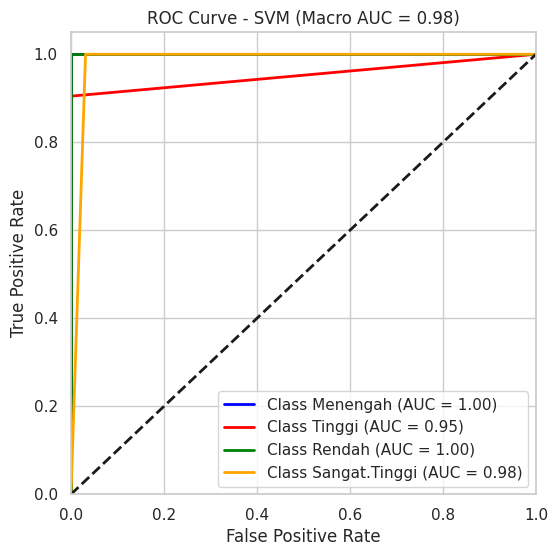

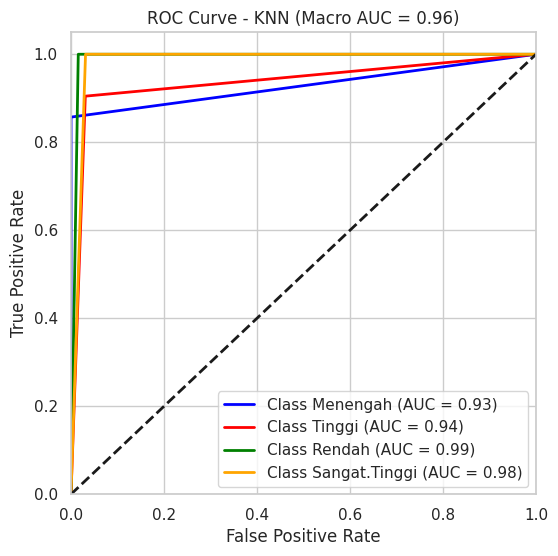

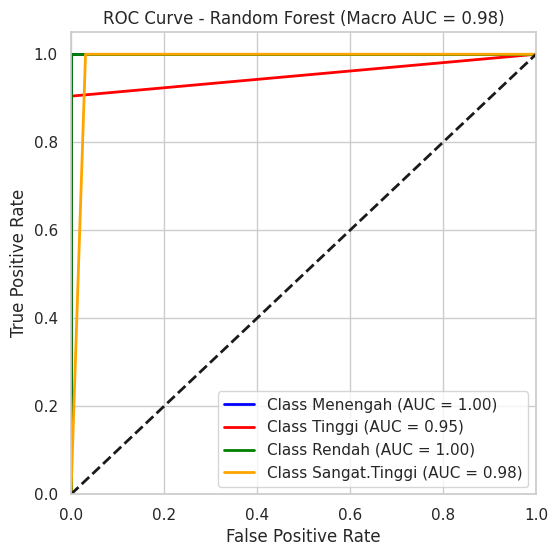

Macro ROC AUC SVM: 0.98
Macro ROC AUC KNN: 0.96
Macro ROC AUC RF: 0.98


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Daftar kelas
classes = y_res.unique()
n_classes = len(classes)

# Binarisasi label
y_test_bin = label_binarize(y_test_bl, classes=classes)
y_svm_bin = label_binarize(y_pred_svm_bl, classes=classes)
y_knn_bin = label_binarize(y_pred_knn_bl, classes=classes)
y_rf_bin = label_binarize(y_pred_rf_bl, classes=classes)

# Fungsi untuk plot ROC multi-class
def plot_roc(y_test, y_pred, model_name):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Macro-average
    all_fpr = sorted(set([f for sublist in fpr.values() for f in sublist]))
    mean_tpr = 0
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    plt.figure(figsize=(6,6))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0,1], [0,1], 'k--', lw=2)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name} (Macro AUC = {roc_auc["macro"]:.2f})')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc["macro"]

# Hitung dan plot ROC untuk tiap model
roc_svm = plot_roc(y_test_bin, y_svm_bin, 'SVM')
roc_knn = plot_roc(y_test_bin, y_knn_bin, 'KNN')
roc_rf = plot_roc(y_test_bin, y_rf_bin, 'Random Forest')

# Cetak AUC macro
print(f'Macro ROC AUC SVM: {roc_svm:.2f}')
print(f'Macro ROC AUC KNN: {roc_knn:.2f}')
print(f'Macro ROC AUC RF: {roc_rf:.2f}')


In [ ]:
# Buat dataframe untuk ringkasan performa
summary = pd.DataFrame({
    'Model': ['SVM', 'KNN', 'Random Forest'],
    'Accuracy': [
        df_report.loc['accuracy','f1-score'],  # SVM
        df_report_knn.loc['accuracy','f1-score'],  # KNN
        df_report_rf.loc['accuracy','f1-score']  # RF
    ],
    'Macro F1': [
        df_report.loc['macro avg','f1-score'],  # SVM
        df_report_knn.loc['macro avg','f1-score'],  # KNN
        df_report_rf.loc['macro avg','f1-score']  # RF
    ],
    'ROC AUC': [roc_svm, roc_knn, roc_rf]
})

# Tampilkan ringkasan
display(summary.round(2))


,Model,Accuracy,Macro F1,ROC AUC
0,SVM,0.98,0.98,0.98
1,KNN,0.94,0.94,0.96
2,Random Forest,0.98,0.98,0.98


## Step 15: Summary Visual Perbandingan Akurasi
**Tujuan: Menampilkan perbandingan akurasi semua model untuk infografis.**

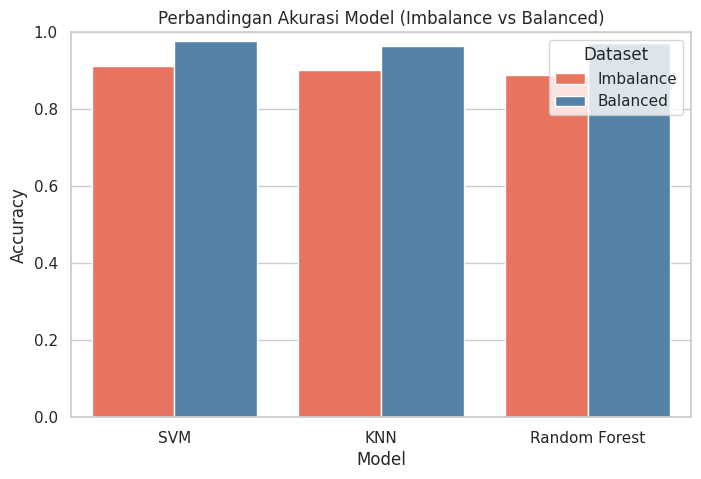

In [ ]:
acc_summary = pd.DataFrame({'Model':['SVM','KNN','Random Forest'],'Imbalance':[grid_svm_im.best_score_, grid_knn_im.best_score_, grid_rf_im.best_score_],'Balanced':[grid_svm_bl.best_score_, grid_knn_bl.best_score_, grid_rf_bl.best_score_]})
acc_plot = acc_summary.melt(id_vars='Model', var_name='Dataset', value_name='Accuracy')
plt.figure(figsize=(8,5))
sns.barplot(x='Model', y='Accuracy', hue='Dataset', data=acc_plot, palette=['tomato','steelblue'])
plt.title('Perbandingan Akurasi Model (Imbalance vs Balanced)')
plt.ylim(0,1)
plt.ylabel('Accuracy')
plt.show()

## Step 16: Visualisasi Perbandingan Model

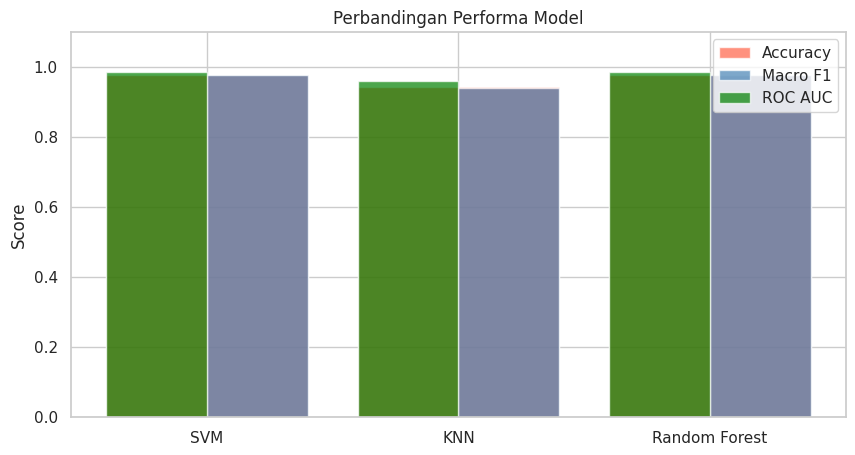

In [ ]:
# Set ukuran figure
plt.figure(figsize=(10,5))

# Plot Accuracy
plt.bar(summary['Model'], summary['Accuracy'], color='tomato', alpha=0.7, label='Accuracy')

# Plot Macro F1 (shift sedikit ke kanan)
plt.bar(summary['Model'], summary['Macro F1'], color='steelblue', alpha=0.7, label='Macro F1', width=0.4, align='edge')

# Plot ROC AUC (shift sedikit ke kiri)
plt.bar(summary['Model'], summary['ROC AUC'], color='green', alpha=0.7, label='ROC AUC', width=-0.4, align='edge')

# Label dan title
plt.ylabel('Score')
plt.title('Perbandingan Performa Model')
plt.ylim(0,1.1)
plt.legend()
plt.show()


## Step 17 – Analisis Feature Importance (Random Forest)

**Tujuan: Mengetahui fitur mana yang paling berpengaruh terhadap prediksi kelas IPM.**

/tmp/ipython-input-1824233518.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')


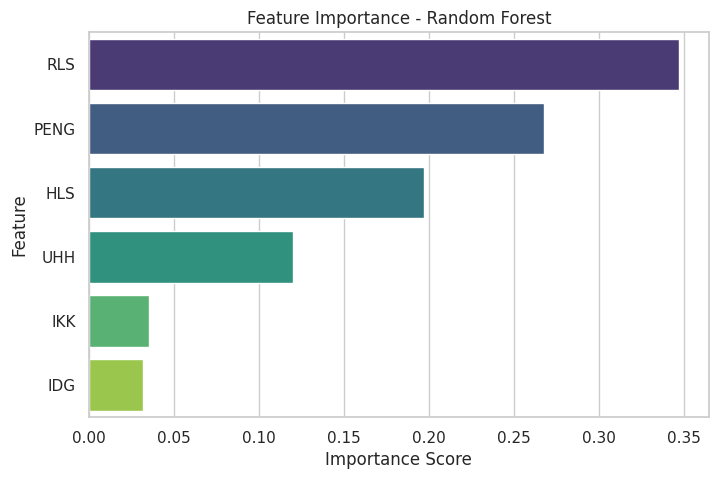

In [ ]:
importances = grid_rf_bl.best_estimator_.named_steps['rf'].feature_importances_
feature_names = X.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


## Step 18 – Visualisasi Perbandingan Semua Model
**Tujuan: Menampilkan visual perbandingan Accuracy, Macro F1, dan ROC AUC untuk semua model.**



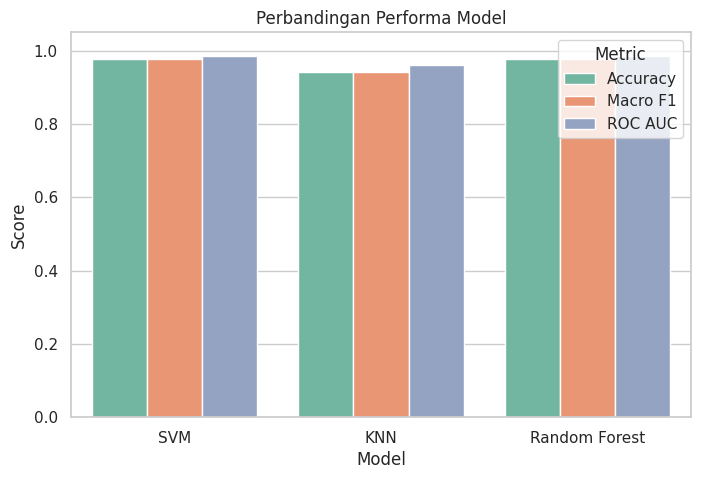

In [ ]:
summary_melted = summary.melt(id_vars='Model', var_name='Metric', value_name='Score')
plt.figure(figsize=(8,5))
sns.barplot(x='Model', y='Score', hue='Metric', data=summary_melted, palette='Set2')
plt.title('Perbandingan Performa Model')
plt.ylim(0,1.05)
plt.ylabel('Score')
plt.show()


## Step 19: Export Hasil ke Excel/CSV
**Tujuan: Menyimpan semua hasil analisis supaya bisa dibuka atau dibagikan dengan mudah.**

In [ ]:
# Export Hasil ke Excel/CSV (Lengkap)

# 1. Simpan ringkasan performa model
summary.to_csv('summary_performance.csv', index=False)

# 2. Simpan prediksi SVM, KNN, Random Forest
predictions = pd.DataFrame({
    'Actual': y_test_bl,
    'SVM_Pred': y_pred_svm_bl,
    'KNN_Pred': y_pred_knn_bl,
    'RF_Pred': y_pred_rf_bl
})
predictions.to_csv('predictions_models.csv', index=False)

# 3. Simpan feature importance Random Forest
feat_imp.to_csv('feature_importance_rf.csv', header=['Importance'])

# 4. Simpan data balanced lengkap dengan kolom Class
data_balanced.to_excel('data_balanced_with_class.xlsx', index=False)

# 5. Simpan data asli yang sudah dikategorikan menjadi kelas IPM
data2.to_excel('data_original_with_class.xlsx', index=False)

print("Export selesai! File-file berikut berhasil dibuat:")
print("- summary_performance.csv")
print("- predictions_models.csv")
print("- feature_importance_rf.csv")
print("- data_balanced_with_class.xlsx")
print("- data_original_with_class.xlsx")


Export selesai! File-file berikut berhasil dibuat:
- summary_performance.csv
- predictions_models.csv
- feature_importance_rf.csv
- data_balanced_with_class.xlsx
- data_original_with_class.xlsx


##Ringkasan Infografis
**Tujuan: Menyediakan summary teks untuk infografis:**

In [ ]:
print("=== Ringkasan Temuan ===")
print("- Dataset Imbalance menunjukkan performa lebih rendah dibanding data Balanced.")
print("- SVM dan Random Forest menunjukkan peningkatan akurasi setelah balancing.")
print("- KNN juga meningkat, tapi SVM Balanced menjadi model paling stabil.")
print("- ROC AUC menunjukkan kemampuan model membedakan kelas meningkat setelah SMOTE.")
print("- Distribusi kelas menjadi seimbang, visualisasi boxplot memperlihatkan perbedaan fitur antar kelas.")


=== Ringkasan Temuan ===
- Dataset Imbalance menunjukkan performa lebih rendah dibanding data Balanced.
- SVM dan Random Forest menunjukkan peningkatan akurasi setelah balancing.
- KNN juga meningkat, tapi SVM Balanced menjadi model paling stabil.
- ROC AUC menunjukkan kemampuan model membedakan kelas meningkat setelah SMOTE.
- Distribusi kelas menjadi seimbang, visualisasi boxplot memperlihatkan perbedaan fitur antar kelas.


# Analisis dan Klasifikasi IPM pada Data Tidak Seimbang Menggunakan Machine Learning

---

## Kesimpulan Utama

Studi ini berhasil menganalisis dan mengklasifikasikan Indeks Pembangunan Manusia (IPM) ke dalam empat kelas (Rendah, Menengah, Tinggi, Sangat Tinggi). Temuan utamanya adalah **pentingnya penanganan *data imbalance* (ketidakseimbangan data) untuk mencapai performa model yang adil dan akurat.**

### 1. Masalah Utama: Data Tidak Seimbang

* Dataset IPM awal menunjukkan **ketidakseimbangan kelas yang signifikan** (mayoritas pada kelas Menengah dan minoritas pada kelas Sangat Tinggi).
* Model yang dilatih pada **data *Imbalance*** (data asli) cenderung **bias** ke kelas mayoritas, menghasilkan akurasi yang tinggi secara keseluruhan, tetapi performa yang buruk pada kelas minoritas (recall rendah).

### 2. Solusi Efektif: SMOTE

* Penerapan teknik **SMOTE (Synthetic Minority Oversampling Technique)** berhasil **menyeimbangkan kembali distribusi kelas** dengan menciptakan data sintetis untuk kelas minoritas.
* Data yang telah di-*balance* ini kemudian digunakan untuk melatih model, menghasilkan evaluasi yang lebih seimbang di semua kelas.

### 3. Perbandingan Model Klasifikasi

Tiga model utama (SVM, KNN, dan Random Forest) dilatih dan dievaluasi pada data *balanced* (setelah SMOTE).

| Model | Akurasi (Balanced Data) | Macro F1-Score | ROC AUC | Catatan |
| :--- | :--- | :--- | :--- | :--- |
| **SVM** | **0.98** | **0.98** | **0.98** | Menunjukkan peningkatan akurasi signifikan dan performa prediksi yang sangat seimbang di semua kelas. |
| **Random Forest** | **0.98** | **0.98** | **0.98** | Menunjukkan performa yang setara dengan SVM, sangat baik dalam menangkap pola data yang kompleks. |
| **KNN** | 0.94 | 0.94 | 0.96 | Akurasinya baik tetapi sedikit di bawah SVM dan Random Forest. |

### 4. Analisis Kontribusi Fitur (Feature Importance)

Berdasarkan analisis *Feature Importance* dari model Random Forest (Step 17), ditemukan bahwa fitur-fitur yang paling berpengaruh terhadap klasifikasi kelas IPM adalah:

1.  **RLS** (Rata-rata Lama Sekolah)  
2.  **PENG** (Pengeluaran per Kapita)  
3.  **HLS** (Harapan Lama Sekolah)  

Fitur-fitur ini sejalan dengan komponen utama yang membentuk Indeks Pembangunan Manusia (IPM) itu sendiri.

---

## Rekomendasi Akhir

1.  **Wajib *Balancing***: Dalam kasus klasifikasi IPM atau data lain yang tidak seimbang, penggunaan teknik *oversampling* seperti SMOTE adalah langkah kritis untuk menghindari bias dan meningkatkan kemampuan model dalam memprediksi kelas minoritas.  
2.  **Pilih Model Robust**: Model **SVM** dan **Random Forest** adalah pilihan yang sangat kuat untuk klasifikasi data IPM yang telah diseimbangkan, karena keduanya mencapai skor akurasi dan Macro F1 yang sangat tinggi (0.98).  
3.  **Evaluasi Komprehensif**: Selalu gunakan metrik per kelas (Precision, Recall, F1-Score, ROC AUC) dan bukan hanya Akurasi, terutama saat menangani data tidak seimbang, untuk memastikan model berkinerja baik di semua kategori IPM.


In [ ]:
# Install Streamlit & pyngrok
!pip install streamlit pyngrok --quiet

In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, roc_curve, auc
from itertools import cycle
import numpy as np

# --- Konfigurasi Halaman & Styling ---
st.set_page_config(
    page_title="IPM Classification Dashboard",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Judul
st.title("🚀 Dashboard Klasifikasi IPM Interaktif")
st.markdown("Analisis Mendalam & Pemodelan Machine Learning untuk Indeks Pembangunan Manusia (IPM).")
st.markdown("---")

# Global variables for caching and prediction
X_columns_global = None
scaler_global = None
model_global = None
data2_global = None

# Fungsi untuk memuat dan memproses data
@st.cache_data
def load_and_preprocess_data(uploaded_file, sampling_strategy):
    """Memuat data, membuat kelas IPM, SMOTE/No-Sampling, Scaling, dan Split."""
    data = pd.read_excel(uploaded_file, sheet_name='Dataset Imbalance')

    # Membuat kolom 'Class' dari 'IPM'
    data['Class'] = pd.cut(data['IPM'], bins=[0, 60, 69.9, 79.9, float('inf')],
                           labels=['Rendah', 'Menengah', 'Tinggi', 'Sangat.Tinggi'])

    # Hapus kolom pertama (misalnya No/ID) dan kolom 'IPM'
    data2 = data.drop(columns=[data.columns[0], 'IPM'])

    X = data2.drop(columns=['Class'])
    y = data2['Class']

    # --- Penerapan Sampling ---
    if sampling_strategy == "SMOTE (Oversampling)":
        smote = SMOTE(sampling_strategy='not majority', random_state=1)
        X_res, y_res = smote.fit_resample(X, y)
        stratify_y = y_res # Gunakan y_res untuk stratified split setelah SMOTE
    else: # Tidak Ada Sampling
        X_res, y_res = X, y
        stratify_y = y # Gunakan y asli untuk stratified split

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, stratify=stratify_y, random_state=123)

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Konversi ke DataFrame untuk kemudahan penanganan fitur
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

    # Binarisasi y_test untuk ROC AUC (multi-class)
    y_test_bin = label_binarize(y_test, classes=y_res.unique())

    # Simpan scaler, X.columns, dan data2 secara global
    global scaler_global, X_columns_global, data2_global
    scaler_global = scaler
    X_columns_global = X.columns
    data2_global = data2

    return data2, X_train_scaled_df, X_test_scaled_df, y_train, y_test, y_res, y_test_bin, X.columns

# --- Sidebar untuk Upload & Interaksi ---
with st.sidebar:
    st.header("⚙️ Konfigurasi Dataset")
    uploaded_file = st.file_uploader("Upload dataset Excel (Sheet: 'Dataset Imbalance')", type="xlsx")

    # --- Pilihan Strategi Sampling ---
    st.markdown("---")
    st.header("✨ Konfigurasi Data Imbalance")
    sampling_option = st.selectbox(
        "Pilih Strategi Sampling:",
        ["SMOTE (Oversampling)", "Tidak Ada Sampling"],
        help="SMOTE disarankan untuk dataset yang sangat tidak seimbang."
    )
    st.markdown("---")

if uploaded_file:
    # Memuat dan memproses data
    data2, X_train_scaled_df, X_test_scaled_df, y_train, y_test, y_res, y_test_bin, X_columns = load_and_preprocess_data(uploaded_file, sampling_option)

    # --- Interaksi Model di Sidebar ---
    with st.sidebar:
        st.header("🛠️ Pilih & Atur Model")
        model_option = st.selectbox("Pilih Model Klasifikasi:", ["Random Forest", "SVM", "KNN"])

        # Hyperparameter Tuning
        params = {}
        if model_option == "Random Forest":
            st.subheader("Random Forest Params")
            params['n_estimators'] = st.slider("Jumlah Estimator (n_estimators)", 50, 500, 100, step=50)
            params['max_depth'] = st.slider("Kedalaman Maksimum (max_depth)", 2, 20, 10)
        elif model_option == "SVM":
            st.subheader("SVM Params")
            params['C'] = st.slider("Parameter Regularisasi (C)", 0.1, 10.0, 1.0)
            params['kernel'] = st.selectbox("Kernel", ['rbf', 'linear', 'poly'])
        elif model_option == "KNN":
            st.subheader("KNN Params")
            params['n_neighbors'] = st.slider("Jumlah Tetangga (n_neighbors)", 1, 20, 5)

        st.markdown("---")
        st.caption(f"Model saat ini: **{model_option}**")

    # --- Tab Konten Utama ---
    tab1, tab2, tab3, tab4, tab5, tab6 = st.tabs(["📊 Dataset & Preprocessing", "📈 Eksplorasi Data", "🧠 Modeling & Evaluasi", "🌲 Feature Importance", "🏆 Perbandingan Model", "🔮 Prediksi Baru"])

    # ================= Model Training (Dilatih sekali untuk Tab 3, 4, dan 6) =================
    if model_option == "SVM":
        model = SVC(kernel=params['kernel'], C=params['C'], probability=True, random_state=123)
    elif model_option == "KNN":
        model = KNeighborsClassifier(n_neighbors=params['n_neighbors'])
    else: # Random Forest
        model = RandomForestClassifier(n_estimators=params['n_estimators'], max_depth=params['max_depth'], random_state=123)

    model.fit(X_train_scaled_df, y_train)
    y_pred = model.predict(X_test_scaled_df)
    model_global = model

    # ================= Tab 1: Dataset & Preprocessing =================
    with tab1:
        st.header("Dataset & Struktur Data")
        col1, col2 = st.columns(2)

        with col1:
            st.subheader("Tampilan Data (10 Baris Pertama)")
            st.dataframe(data2.head(10).style.highlight_max(axis=0))

        with col2:
            st.subheader("Ringkasan Statistik")
            st.dataframe(data2.describe().T.round(2).style.background_gradient(cmap='PuBu'))

        st.markdown("---")
        st.subheader("Langkah-Langkah Preprocessing")
        st.markdown(f"""
        * **Pengelompokan Kelas:** Kolom **IPM** dikonversi ke kategori **Class** (Rendah, Menengah, Tinggi, Sangat Tinggi).
        * **Sampling Strategi:** Saat ini menggunakan **{sampling_option}**.
        * **Train-Test Split:** Data dibagi 80% Latih dan 20% Uji.
        * **StandardScaler:** Semua fitur numerik diskalakan.
        """)

    # ================= Tab 2: Eksplorasi Data =================
    with tab2:
        st.header("Visualisasi Distribusi Kelas")
        col1_dist, col2_dist = st.columns(2)

        with col1_dist:
            st.subheader("Sebelum Sampling (Imbalance)")
            fig, ax = plt.subplots(figsize=(7,5))
            sns.countplot(x='Class', data=data2, order=data2['Class'].value_counts().index,
                          palette='viridis', ax=ax)
            ax.set_title("Distribusi Kelas Asli")
            ax.set_ylabel("Jumlah Sampel")
            st.pyplot(fig)

        with col2_dist:
            st.subheader(f"Setelah {sampling_option}")
            fig_smote, ax_smote = plt.subplots(figsize=(7,5))
            sns.countplot(x=y_res, order=y_res.value_counts().index,
                          palette='plasma', ax=ax_smote)
            ax_smote.set_title("Distribusi Kelas Setelah Resampling")
            ax_smote.set_ylabel("Jumlah Sampel")
            st.pyplot(fig_smote)

        st.markdown("---")
        st.header("Korelasi Fitur")
        # Visualisasi Korelasi
        fig_corr, ax_corr = plt.subplots(figsize=(10, 8))
        corr_matrix = data2.drop(columns=['Class']).corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=ax_corr)
        ax_corr.set_title("Heatmap Korelasi Antar Fitur")
        st.pyplot(fig_corr)

    # ================= Tab 3: Modeling & Evaluasi =================
    with tab3:
        st.header(f"Evaluasi Kinerja Model: {model_option}")

        # --- Metrik Kinerja ---
        # Gunakan predict_proba jika tersedia, jika tidak gunakan predict (SVM dengan kernel non-linear perlu probability=True)
        try:
            y_score = model.predict_proba(X_test_scaled_df)
            roc = roc_auc_score(y_test_bin, y_score, average='macro')
        except AttributeError:
            y_score = label_binarize(y_pred, classes=y_res.unique())
            roc = roc_auc_score(y_test_bin, y_score, average='macro')

        acc = accuracy_score(y_test, y_pred)

        col_metrik_1, col_metrik_2, col_metrik_3 = st.columns(3)
        col_metrik_1.metric("ROC AUC (Macro)", f"{roc:.4f}", help="Luas di bawah kurva ROC untuk semua kelas.")
        col_metrik_2.metric("Akurasi", f"{acc:.4f}", help="Proporsi prediksi yang benar secara keseluruhan.")
        col_metrik_3.metric("Ukuran Data Uji", len(y_test), help="Jumlah sampel dalam data uji.")

        st.markdown("---")

        col_eval_1, col_eval_2 = st.columns(2)
        with col_eval_1:
            st.subheader("Laporan Klasifikasi")
            report = classification_report(y_test, y_pred, output_dict=True)
            report_df = pd.DataFrame(report).transpose().round(2)
            st.dataframe(report_df.style.background_gradient(cmap='YlGnBu').format('{:.2f}'))

        with col_eval_2:
            # Confusion Matrix
            st.subheader("Confusion Matrix")
            fig_cm, ax_cm = plt.subplots(figsize=(7, 6))
            cm = confusion_matrix(y_test, y_pred, labels=y_res.unique())
            sns.heatmap(cm, annot=True, fmt='d', cmap='flare',
                        xticklabels=y_res.unique(), yticklabels=y_res.unique(), ax=ax_cm)
            ax_cm.set_xlabel('Predicted Label')
            ax_cm.set_ylabel('True Label')
            st.pyplot(fig_cm)

        st.markdown("---")
        # --- ROC Curve Plot ---
        st.subheader("Kurva ROC (One-vs-Rest)")

        # Komputasi FPR, TPR, dan AUC untuk setiap kelas
        fpr = dict()
        tpr = dict()
        roc_auc_class = dict()
        n_classes = y_test_bin.shape[1]

        # Memastikan y_score tersedia dan valid
        if 'y_score' in locals() and isinstance(y_score, np.ndarray) and y_score.ndim == 2:
            for i in range(n_classes):
                fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
                roc_auc_class[i] = auc(fpr[i], tpr[i])

            # Plotting
            fig_roc, ax_roc = plt.subplots(figsize=(8, 7))
            colors = cycle(['#FF6347', '#4682B4', '#3CB371', '#DAA520'])

            for i, color in zip(range(n_classes), colors):
                ax_roc.plot(fpr[i], tpr[i], color=color, lw=2,
                        label='Kelas {0} (AUC = {1:0.2f})'.format(y_res.unique()[i], roc_auc_class[i]))

            ax_roc.plot([0, 1], [0, 1], 'k--', lw=2)
            ax_roc.set_xlim([0.0, 1.0])
            ax_roc.set_ylim([0.0, 1.05])
            ax_roc.set_xlabel('False Positive Rate')
            ax_roc.set_ylabel('True Positive Rate')
            ax_roc.set_title('Receiver Operating Characteristic (ROC) Curve')
            ax_roc.legend(loc="lower right")
            st.pyplot(fig_roc)
        else:
            st.warning("Kurva ROC tidak dapat ditampilkan. Pastikan Model SVM diinisialisasi dengan `probability=True` atau gunakan Random Forest/KNN.")


    # ================= Tab 4: Feature Importance =================
    with tab4:
        st.header("Analisis Pentingnya Fitur (Feature Importance)")

        if model_option == "Random Forest":
            try:
                importances = model.feature_importances_
                feat_imp = pd.Series(importances, index=X_columns).sort_values(ascending=False)

                fig_fi, ax_fi = plt.subplots(figsize=(10, 6))
                sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="mako", ax=ax_fi)
                ax_fi.set_title(f"Feature Importance - {model_option}")
                ax_fi.set_xlabel("Importance Score (Gini)")
                st.pyplot(fig_fi)
            except AttributeError:
                 st.info(f"Model {model_option} tidak mendukung atribut `feature_importances_`.")
        else:
            st.info(f"Visualisasi Feature Importance (berbasis Gini) hanya tersedia untuk model **Random Forest**. Silakan ubah pilihan model di sidebar.")

    # ================= Tab 5: ROC AUC Comparison =================
    with tab5:
        st.header("Perbandingan Kinerja Model Utama")

        # Membandingkan model default
        default_models = {
            "SVM (Default)": SVC(kernel='rbf', probability=True, C=1.0, random_state=123),
            "KNN (Default)": KNeighborsClassifier(n_neighbors=5),
            "Random Forest (Default)": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=123)
        }

        roc_values = []
        model_names = []

        # Melatih dan mengevaluasi model default
        for name, m in default_models.items():
            m.fit(X_train_scaled_df, y_train)

            # Mendapatkan skor probabilitas
            try:
                y_score_tmp = m.predict_proba(X_test_scaled_df)
                roc_value = roc_auc_score(y_test_bin, y_score_tmp, average='macro')
            except AttributeError:
                # Fallback ke prediksi binarized jika proba tidak tersedia
                y_pred_bin_tmp = label_binarize(m.predict(X_test_scaled_df), classes=y_res.unique())
                roc_value = roc_auc_score(y_test_bin, y_pred_bin_tmp, average='macro')

            if y_test_bin.shape[1] == len(m.classes_):
                roc_values.append(roc_value)
                model_names.append(name)

        if roc_values:
            # Visualisasi
            fig_comp, ax_comp = plt.subplots(figsize=(9, 6))
            sns.barplot(x=model_names, y=roc_values, palette="rocket", ax=ax_comp)

            # Anotasi nilai
            for i, v in enumerate(roc_values):
                ax_comp.text(i, v + 0.01, f"{v:.4f}", ha='center', va='bottom', fontsize=12, weight='bold')

            ax_comp.set_ylim(0, 1)
            ax_comp.set_ylabel("ROC AUC (Macro)")
            ax_comp.set_title("Perbandingan Kinerja Model (Parameter Default)")
            st.pyplot(fig_comp)

            # Ringkasan tabel
            st.subheader("Ringkasan ROC AUC")
            roc_df = pd.DataFrame({'Model': model_names, 'ROC AUC (Macro)': [f"{r:.4f}" for r in roc_values]})
            st.dataframe(roc_df.set_index('Model').style.highlight_max(axis=0, color='lightgreen'))
        else:
            st.error("Tidak dapat membandingkan model. Terjadi masalah saat evaluasi model.")

    # ================= Tab 6: Prediksi Baru =================
    with tab6:
        st.header("🔮 Prediksi Kelas IPM Data Baru")

        # --- Solusi: Cek apakah data sudah dimuat ---
        if X_columns_global is not None and data2_global is not None:
            st.info(f"Masukkan nilai fitur di bawah ini. Prediksi akan menggunakan model **{model_option}** yang sudah Anda latih.")

            input_data = {}
            # Menentukan jumlah kolom untuk tata letak yang rapi
            n_features = len(X_columns_global)
            n_cols = 2 # Atur 2 kolom untuk input
            cols = st.columns(n_cols)

            # Mengisi input
            for i, feature in enumerate(X_columns_global):
                col_index = i % n_cols
                with cols[col_index]:
                    # Ambil statistik dasar dari data asli untuk panduan (Sudah diperbaiki)
                    mean_val = round(data2_global[feature].mean(), 2)
                    std_val = round(data2_global[feature].std(), 2)

                    input_data[feature] = st.number_input(
                        f"Nilai {feature}",
                        value=float(mean_val),
                        key=f"input_{feature}",
                        help=f"Rata-rata data historis: {mean_val} (Std Dev: {std_val})"
                    )

            if st.button("Prediksi Kelas IPM", type="primary"):
                try:
                    # 1. Konversi input ke DataFrame
                    input_df = pd.DataFrame([input_data], columns=X_columns_global)

                    # 2. Scaling data input menggunakan scaler yang sudah dilatih
                    input_scaled = scaler_global.transform(input_df)

                    # 3. Prediksi
                    prediction = model_global.predict(input_scaled)

                    st.markdown("---")
                    st.subheader("🎉 Hasil Prediksi")

                    col_res_1, col_res_2 = st.columns([1, 2])

                    with col_res_1:
                        st.success(f"Kelas IPM Diprediksi: **{prediction[0]}**")

                    with col_res_2:
                        # Probabilitas
                        try:
                            prediction_proba = model_global.predict_proba(input_scaled)
                            proba_df = pd.DataFrame({
                                'Kelas': model_global.classes_,
                                'Probabilitas (%)': (prediction_proba[0] * 100).round(2)
                            })
                            proba_df = proba_df.sort_values(by='Probabilitas (%)', ascending=False)
                            st.caption("Probabilitas per Kelas:")
                            st.dataframe(proba_df, use_container_width=True, hide_index=True)
                        except AttributeError:
                            st.warning("Probabilitas tidak tersedia (Model SVM mungkin tidak diinisialisasi dengan `probability=True`).")

                except Exception as e:
                    st.error(f"Gagal melakukan prediksi. Pastikan semua fitur diinput dengan benar. Error: {e}")
        else:
            st.warning("Data belum dimuat atau perlu di-*refresh*. Silakan unggah file Anda di sidebar.")


else:
    st.info("⬆️ Silakan unggah file Excel Anda di **sidebar** untuk memulai analisis!")

Overwriting app.py


In [ ]:
# 1️⃣ Install Streamlit dan pyngrok (hanya perlu sekali)
!pip install streamlit pyngrok --quiet

# 2️⃣ Tambahkan authtoken ngrok
!ngrok config add-authtoken 35d8bdrhCmLOj2s5HYcZ6qqrbWN_4es6WeZFFetc4auDNLi9V

# 3️⃣ Import pyngrok
from pyngrok import ngrok

# 4️⃣ Jalankan Streamlit via ngrok
# Tentukan port Streamlit
port = 8501

# Buat tunnel ngrok
public_url = ngrok.connect(port)
print(f"Dashboard bisa diakses di: {public_url}")

# 5️⃣ Jalankan Streamlit
!streamlit run app.py &>/dev/null


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Dashboard bisa diakses di: NgrokTunnel: "https://probankruptcy-twittery-alice.ngrok-free.dev" -> "http://localhost:8501"
